In [1]:
import os
import math
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
TRAIN_PATH = "data/train_FD002.txt"
TEST_PATH  = "data/test_FD002.txt"
RUL_PATH   = "data/RUL_FD002.txt"   # final RUL for test engines

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

SEQ_LEN = 80           # window length (try 30-80)
STEP = 1
BATCH_SIZE = 128
EPOCHS = 100
PATIENCE = 15

RUL_CLIP = 125.0

LR = 3e-3
WEIGHT_DECAY = 1e-5
GRAD_CLIP = 1.0

# sensors / features used (same as your earlier selection)
selected_features = [
    "op_setting_1","op_setting_2","op_setting_3",
    "sensor_2","sensor_3","sensor_4","sensor_7","sensor_8",
    "sensor_9","sensor_11","sensor_12","sensor_13","sensor_14","sensor_15"
]


Device: cpu


In [3]:
def load_cmapss(path):
    # read whitespace-separated file, drop trailing NaN cols
    df = pd.read_csv(path, sep=r"\s+", header=None, engine='python')
    # CMAPSS convention: first 2 columns: unit, cycle; next 3 op-settings; then 21 sensors
    cols = ["unit", "cycle"] + [f"op_setting_{i}" for i in range(1,4)] + [f"sensor_{i}" for i in range(1,22)]
    df = df.iloc[:, :len(cols)]
    df.columns = cols
    return df

def compute_rul_train(df, clip=RUL_CLIP):
    # df must contain unit and cycle
    max_by_unit = df.groupby('unit')['cycle'].max().to_dict()
    df['RUL'] = df.apply(lambda r: max_by_unit[r['unit']] - r['cycle'], axis=1)
    df['RUL'] = df['RUL'].clip(0, clip)
    return df

def build_test_rul_map(rul_path, clip=RUL_CLIP):
    vals = np.loadtxt(rul_path)
    units = np.arange(1, len(vals)+1)
    return {int(u): int(min(v, clip)) for u, v in zip(units, vals)}

def create_sequences_for_units(df, units_list, seq_len=SEQ_LEN, step=STEP):
    X, y = [], []
    for uid in sorted(units_list):
        unit_df = df[df['unit'] == uid].reset_index(drop=True)
        feats = unit_df[selected_features].values
        labels = unit_df['RUL'].values
        L = len(unit_df)
        for start in range(0, L - seq_len + 1, step):
            end = start + seq_len
            X.append(feats[start:end])
            # label is the RUL at the last timestep of the window (end-1)
            y.append(labels[end - 1])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

def build_last_windows_for_test(df, seq_len=SEQ_LEN):
    X, units_sorted = [], []
    for uid in sorted(df['unit'].unique()):
        unit_df = df[df['unit'] == uid].reset_index(drop=True)
        feats = unit_df[selected_features].values
        if len(feats) < seq_len:
            pad_len = seq_len - len(feats)
            pad_row = feats[[0], :]
            pad = np.repeat(pad_row, pad_len, axis=0)
            window = np.vstack([pad, feats])
        else:
            window = feats[-seq_len:]
        X.append(window.astype(np.float32))
        units_sorted.append(int(uid))
    return np.array(X, dtype=np.float32), units_sorted

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        # normalize targets: y in [0,RUL_CLIP] -> scale to [0,1]
        self.y = torch.tensor(y / RUL_CLIP, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
class SmallGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.2, bidirectional=True):
        super().__init__()
        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )
        self.norm = nn.LayerNorm(hidden_dim * (2 if bidirectional else 1))
        h = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Sequential(
            nn.Linear(h, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        out, _ = self.gru(x)
        last = out[:, -1, :]
        last = self.norm(last)
        return self.fc(last)

In [5]:
train_df = load_cmapss(TRAIN_PATH)
test_df = load_cmapss(TEST_PATH)
test_rul_map = build_test_rul_map(RUL_PATH, clip=RUL_CLIP)

# compute RUL for training set and clip
train_df = compute_rul_train(train_df, clip=RUL_CLIP)

# keep only selected features + unit, cycle, RUL
train_df = train_df[['unit','cycle'] + selected_features + ['RUL']]
test_df  = test_df[['unit','cycle'] + selected_features].copy()


In [6]:
scaler = StandardScaler()
train_vals = train_df[selected_features].values
train_scaled = scaler.fit_transform(train_vals)
train_df[selected_features] = train_scaled

test_df[selected_features] = scaler.transform(test_df[selected_features].values)

In [7]:
with open("scaler_fd002_corrected.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [8]:
units = sorted(train_df['unit'].unique())
n_units = len(units)
split_idx = int(n_units * 0.8)
train_units = units[:split_idx]
val_units   = units[split_idx:]

print(f"Units: {n_units}  Train units: {len(train_units)}  Val units: {len(val_units)}")


Units: 260  Train units: 208  Val units: 52


In [9]:
X_train, y_train = create_sequences_for_units(train_df, train_units, seq_len=SEQ_LEN, step=STEP)
X_val,   y_val   = create_sequences_for_units(train_df, val_units,   seq_len=SEQ_LEN, step=STEP)

print("Shapes -> X_train:", X_train.shape, "y_train:", y_train.shape, "X_val:", X_val.shape, "y_val:", y_val.shape)


Shapes -> X_train: (26671, 80, 14) y_train: (26671,) X_val: (6548, 80, 14) y_val: (6548,)


In [10]:
train_ds = SeqDataset(X_train, y_train)
val_ds   = SeqDataset(X_val,   y_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# ----------------------------
# Test windows (last window per engine) and true RULs (clipped)
# ----------------------------
X_test_windows, test_units = build_last_windows_for_test(test_df, seq_len=SEQ_LEN)
y_test = np.array([test_rul_map[int(u)] for u in test_units], dtype=np.float32)  # clipped already via map


In [13]:
model = SmallGRU(input_dim=len(selected_features), hidden_dim=128, num_layers=2, dropout=0.2, bidirectional=True).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.SmoothL1Loss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.5,
    patience=5
)


In [14]:
best_val = float("inf")
wait = 0
history = {"train_loss": [], "val_loss": [], "train_mae": [], "val_mae": []}

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        train_loss += loss.item() * Xb.size(0)
        train_mae += torch.nn.functional.l1_loss(pred, yb, reduction='sum').item()
    train_loss /= len(train_loader.dataset)
    train_mae /= len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0.0
    val_mae  = 0.0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            pred = model(Xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * Xb.size(0)
            val_mae  += torch.nn.functional.l1_loss(pred, yb, reduction='sum').item()
    val_loss /= len(val_loader.dataset)
    val_mae /= len(val_loader.dataset)

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_mae"].append(train_mae)
    history["val_mae"].append(val_mae)

    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Train MAE: {train_mae:.6f} | Val MAE: {val_mae:.6f}")

    if val_loss + 1e-8 < best_val:
        best_val = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_gru_fd002_corrected.pth")
        print(f"  -> New best model saved (Val Loss: {best_val:.6f})")
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"Early stopping at epoch {epoch}. Best val loss: {best_val:.6f}")
            break


Epoch 001 | Train Loss: 0.024378 | Val Loss: 0.018273 | Train MAE: 0.170513 | Val MAE: 0.145167
  -> New best model saved (Val Loss: 0.018273)
Epoch 002 | Train Loss: 0.015630 | Val Loss: 0.013795 | Train MAE: 0.137142 | Val MAE: 0.130391
  -> New best model saved (Val Loss: 0.013795)
Epoch 003 | Train Loss: 0.014699 | Val Loss: 0.012506 | Train MAE: 0.133115 | Val MAE: 0.124328
  -> New best model saved (Val Loss: 0.012506)
Epoch 004 | Train Loss: 0.010751 | Val Loss: 0.009154 | Train MAE: 0.111192 | Val MAE: 0.105295
  -> New best model saved (Val Loss: 0.009154)
Epoch 005 | Train Loss: 0.007198 | Val Loss: 0.014573 | Train MAE: 0.090166 | Val MAE: 0.124669
Epoch 006 | Train Loss: 0.006643 | Val Loss: 0.010277 | Train MAE: 0.086271 | Val MAE: 0.103852
Epoch 007 | Train Loss: 0.006103 | Val Loss: 0.013117 | Train MAE: 0.082388 | Val MAE: 0.119310
Epoch 008 | Train Loss: 0.005157 | Val Loss: 0.010603 | Train MAE: 0.075625 | Val MAE: 0.109325
Epoch 009 | Train Loss: 0.004287 | Val Loss:

In [15]:
model.load_state_dict(torch.load("best_gru_fd002_corrected.pth", map_location=DEVICE))
model.to(DEVICE)
model.eval()

SmallGRU(
  (gru): GRU(14, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
)

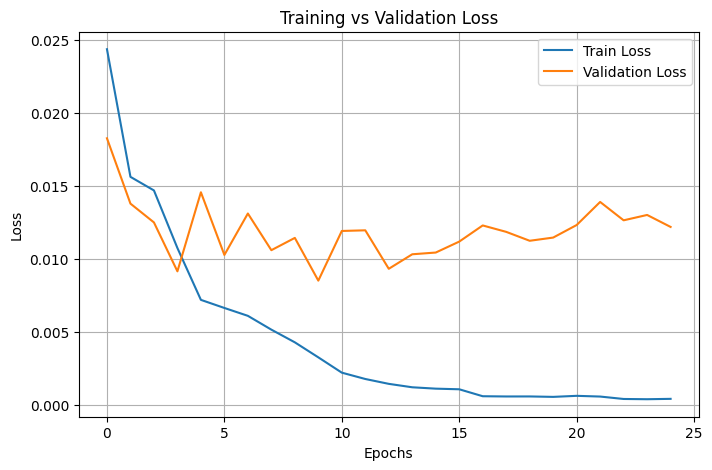

In [23]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
X_test_tensor = torch.tensor(X_test_windows, dtype=torch.float32).to(DEVICE)
with torch.no_grad():
    preds_norm = model(X_test_tensor).cpu().numpy().flatten()

# denormalize predictions
preds = preds_norm * RUL_CLIP
y_true = y_test.copy()

In [24]:
rmse = math.sqrt(mean_squared_error(y_true, preds))
mae = mean_absolute_error(y_true, preds)
print(f"\nTEST RMSE: {rmse:.4f}  MAE: {mae:.4f}")

# per-engine print
print("\nEngine | True RUL | Predicted RUL ")
for u, t, p in zip(test_units, y_true, preds):
    print(f"{u:3d}    {t:7.2f}     {p:7.2f}  ")


TEST RMSE: 16.7212  MAE: 12.4763

Engine | True RUL | Predicted RUL 
  1      18.00       16.65  
  2      79.00      106.08  
  3     106.00       80.76  
  4     110.00       76.58  
  5      15.00       21.25  
  6     125.00      104.93  
  7       6.00        8.79  
  8      90.00       75.09  
  9      11.00       11.22  
 10      79.00       86.28  
 11       6.00        6.25  
 12      73.00       82.27  
 13      30.00       25.21  
 14      11.00       14.66  
 15      37.00       31.03  
 16      67.00       64.70  
 17      68.00       49.33  
 18      99.00      108.13  
 19      22.00       25.24  
 20      54.00       63.21  
 21      97.00       99.96  
 22      10.00        8.70  
 23     125.00       87.86  
 24      77.00       65.25  
 25      88.00       87.67  
 26     125.00      109.04  
 27     125.00      106.74  
 28     125.00       83.82  
 29      83.00      101.45  
 30      78.00       50.37  
 31      75.00       68.11  
 32      11.00       11.99  
 3

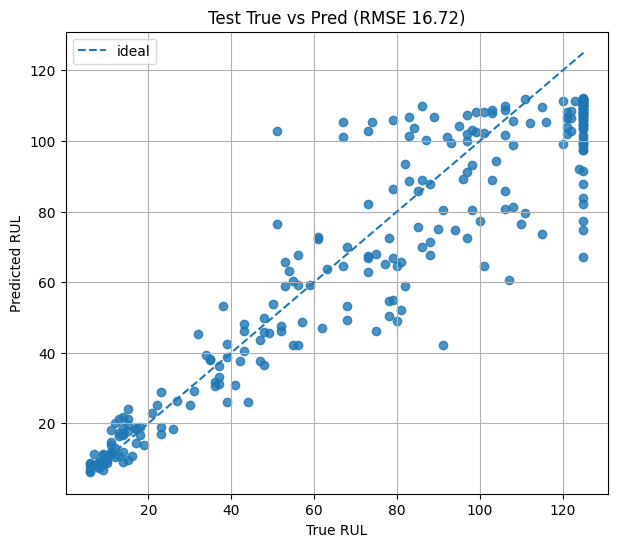

In [19]:
plt.figure(figsize=(7,6))
plt.scatter(y_true, preds, alpha=0.8)
minv = min(y_true.min(), preds.min())
maxv = max(y_true.max(), preds.max())
plt.plot([minv, maxv], [minv, maxv], "--", label="ideal")
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title(f"Test True vs Pred (RMSE {rmse:.2f})")
plt.legend()
plt.grid(True)
plt.show()

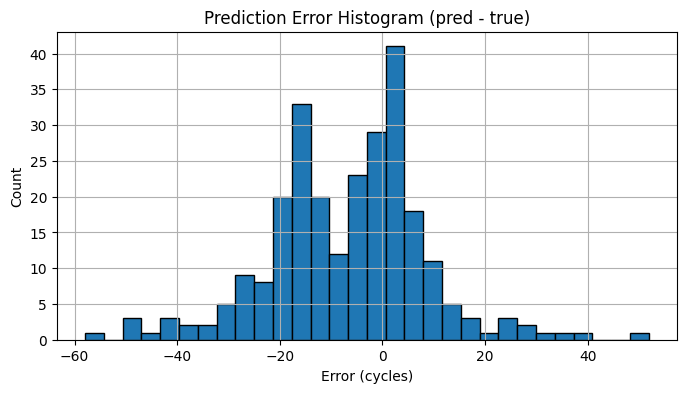

In [20]:
errors = preds - y_true
plt.figure(figsize=(8,4))
plt.hist(errors, bins=30, edgecolor='k')
plt.title("Prediction Error Histogram (pred - true)")
plt.xlabel("Error (cycles)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

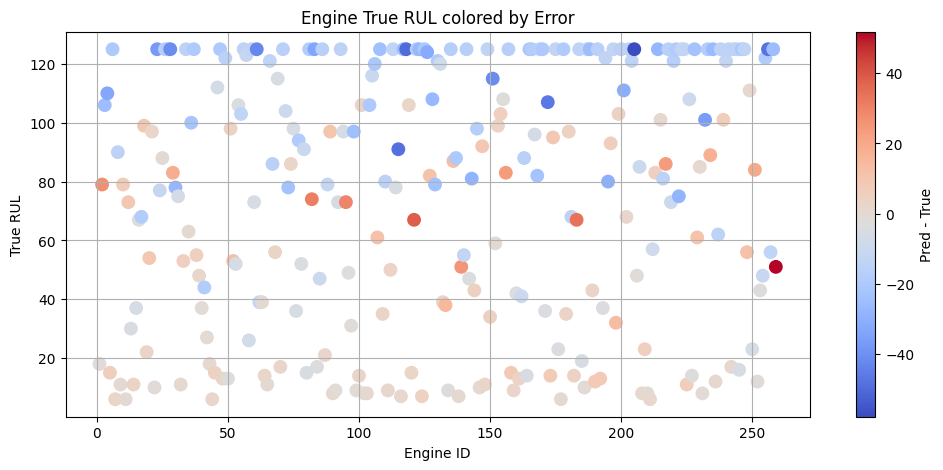

In [21]:
plt.figure(figsize=(12,5))
plt.scatter(test_units, y_true, c=errors, cmap="coolwarm", s=80)
plt.colorbar(label="Pred - True")
plt.xlabel("Engine ID")
plt.ylabel("True RUL")
plt.title("Engine True RUL colored by Error")
plt.grid(True)
plt.show()

In [22]:

# save model + scaler
with open("scaler_fd002_corrected.pkl", "wb") as f:
    pickle.dump(scaler, f)
torch.save(model.state_dict(), "best_gru_fd002_corrected.pth")

print("\nSaved: scaler_fd002_corrected.pkl and best_gru_fd002_corrected.pth")



Saved: scaler_fd002_corrected.pkl and best_gru_fd002_corrected.pth
